In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


import pickle
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score
import dill

In [2]:
# m = dill.load(open('synthetic_rec.pkl', 'rb'))
# model = m.gen_model
# def get_rec_model(m):
#     gen = LDS(z = m.gen_model.z, Y = m.gen_model.Y, lik = m.gen_model.lik, x_dim=m.gen_model.x_dim, link_fn=m.gen_model.link_fn, A=m.gen_model.A, C=m.gen_model.C, W=m.gen_model.W, B=m.gen_model.B, mu0=m.gen_model.mu0, Sigma0_half=m.gen_model.Sigma0_half, sigma_x=m.gen_model.sigma_x,
#                  trained_z=False, d=m.gen_model.d, fixed_d=True, single_sigma_x=False, full_R=False)
#     gen.freeze_params()
#     rec_model = RecognitionModel(gen, neural_net=m.neural_net, cov_change=False)
#     rec_model.freeze_params()
#     return rec_model, gen
# model = get_rec_model(m)[1]

[[ 0.2782208   0.20921635 -0.15783327 -0.11597944  0.50267757]
 [ 0.20921635  0.62540461 -0.07440552 -0.1590074  -0.34949867]
 [-0.15783327 -0.07440552  0.56790749 -0.23986521 -0.04603175]
 [-0.11597944 -0.1590074  -0.23986521  0.53484125  0.11551827]
 [ 0.50267757 -0.34949867 -0.04603175  0.11551827 -0.10637415]]
(5,) (5, 5)


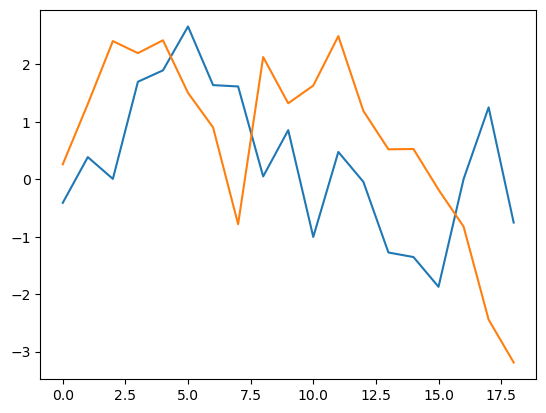

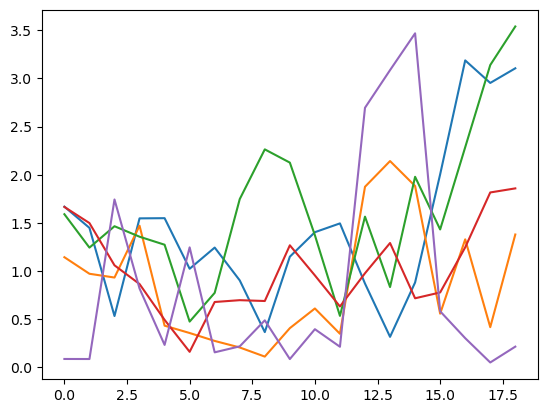

0.8972652412870508


In [2]:
# Simulate some data
torch.manual_seed(0)
np.random.seed(0)
N = 100
z_dim = 5
# x_dim = 5
x_dim = 100
# x_dim = 200

# sqrt m  division in matrix C 

# A = np.array([[0.9, 0.4], [-0.2, 0.8]])
# s = np.array([0.8, 0.99]).reshape(1, -1)
# u, _ = np.linalg.qr(np.random.randn(s.shape[1], s.shape[1]))
# A = u @ np.diag(s.squeeze()) @ u.T
eigs = np.array([-0.6, 0.2, 0.6, 0.8, 0.9])
A = np.diag(eigs)
u, _ = np.linalg.qr(np.random.randn(z_dim, z_dim))
A = u @ A @ u.T
print(A)

# B = np.array([[0.1, 0.0], [0.0, 0.1]])
B = 1 * np.eye(z_dim)
# W = np.eye(x_dim)
W = np.random.randn(x_dim, z_dim) / np.sqrt(z_dim)




C = np.random.randn(N, x_dim) / np.sqrt(x_dim)
# C = np.eye(N)

sigma_x = 0.1

# mu0 = np.array([0., 0.])
# Sigma0 = np.array([[.010, 0.0], [0.0, .010]])
mu0 = np.zeros(z_dim)
Sigma0 = 1 * np.eye(z_dim)
print(mu0.shape, Sigma0.shape)

ntrials = 100
# v0 = np.random.multivariate_normal(mu0, Sigma0)
v0 = mu0 + (np.linalg.cholesky(Sigma0) @ np.random.randn(ntrials,z_dim, 1)).squeeze(-1)

T = 20
v = np.zeros((ntrials,z_dim,T))
x = np.zeros((ntrials,x_dim,T))
x_noise_free = np.zeros((ntrials,x_dim,T))
v[:,:, 0] = v0
x_noise_free[:,:, 0] = (W @ v0[..., None]).squeeze(-1)
x[:,:, 0] = (W @ v0[..., None]).squeeze(-1) + sigma_x * np.random.randn(ntrials, x_dim,)
for t in range(1, T):
    v[..., t] = (A @ v[..., t-1][..., None]).squeeze(-1) + (B @ np.random.randn(ntrials, z_dim,1)).squeeze(-1)
    x_noise_free[..., t] = (W @ v[..., t][..., None]).squeeze(-1)
    x[..., t] = (W @ v[..., t][..., None]).squeeze(-1) + sigma_x * np.random.randn(ntrials, x_dim)

stop = -1
plt.plot(v[-1,0,:stop])
plt.plot(v[-1,1,:stop])
plt.show()

# _d = 0.5
_d = 0
F = C[None, ...] @ x + _d
# plt.plot(F[0,0,:stop])
# plt.plot(F[0,1,:stop])

# link = np.exp
link = lambda x: 1 * np.log(1 + np.exp(x))
dt = 1
for i in range(5):
    plt.plot(link(F[0,i,:stop])*dt)
plt.show()

# Average firing rate
print(np.mean(link(F)))


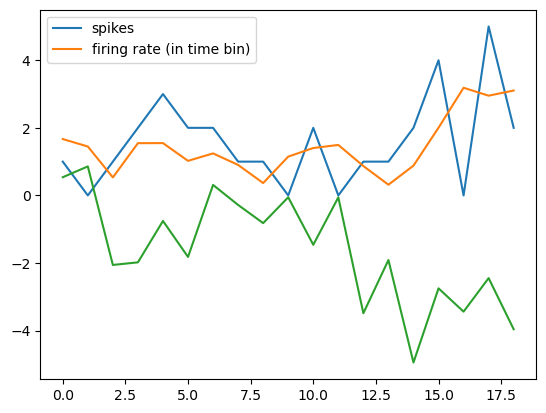

In [3]:
# link_fn = torch.exp
# link = lambda x: np.exp(x)
link_fn = lambda x: 1 * torch.nn.functional.softplus(x)
link = lambda x: 1 * np.log(1 + np.exp(x))
lik = Poisson_noise()
Y = np.random.poisson(link(F)*dt)

# train_len = 1000
# Y_train = Y[..., :train_len]
# v_train = v[..., :train_len]
# Y_test = Y[..., train_len:]
# v_test = v[..., train_len:]

train_trials = 80
Y_train = Y[:train_trials]
v_train = v[:train_trials]
Y_test = Y[train_trials:]
v_test = v[train_trials:]


# sigma = 0.1
# Y = np.random.randn(*F.shape) * sigma + F
# lik = Gaussian_noise(sigma)
# link_fn = lambda x: x

# # Sigmoid link function
# link = lambda x: 1 / (1 + np.exp(-x))
# Y = np.random.negative_binomial(link(F), 0.5)
# lik = Negative_binomial_noise(Tensor(Y))
# link_fn = lambda x:x

plt.plot(Y[0,0,:stop], label='spikes')
# plt.plot(Y[0,1,:stop])
plt.plot(link(F[0,0,:stop])*dt, label='firing rate (in time bin)')
plt.plot(x_noise_free[0,0,:stop])
plt.legend()
plt.show()

# # model = dill.load(open('synthetic_gen_small_t.pkl', 'rb'))

# # model = LDS(Tensor(v_train), Tensor(Y_train), lik, x_dim=x_dim, link_fn=link_fn, fixed_d=False, C=Tensor(C).to(device))
# # model.C.requires_grad = False
# model = LDS(Tensor(v_train), Tensor(Y_train), lik, x_dim=x_dim, link_fn=link_fn, fixed_d=False)

# train_params = {'batch_size': None, 'n_mc': 500, 'step_size': 500, 'lrate': 1e-2, 'max_steps': 1001, 'gamma': 0.85, 'StepLR': True}
# np.random.seed(0)
# torch.manual_seed(0)
# model.train_supervised_model(model.training_params(**train_params))
# model.plot_LL()

# Fixed generative model
model = LDS(Tensor(v_train), Tensor(Y_train), lik, x_dim=x_dim, link_fn=link_fn, 
            A=Tensor(A[None, ...]).to(device), B=Tensor(B[None, ...]).to(device), W=Tensor(W[None,...]).to(device), C=Tensor(C[None, ...]).to(device),
            mu0=Tensor(mu0[None, ...]).to(device), Sigma0_half=Tensor(np.linalg.cholesky(Sigma0)[None, ...]).to(device),
            sigma_x=(torch.ones(x_dim) * sigma_x).to(device), d=_d)

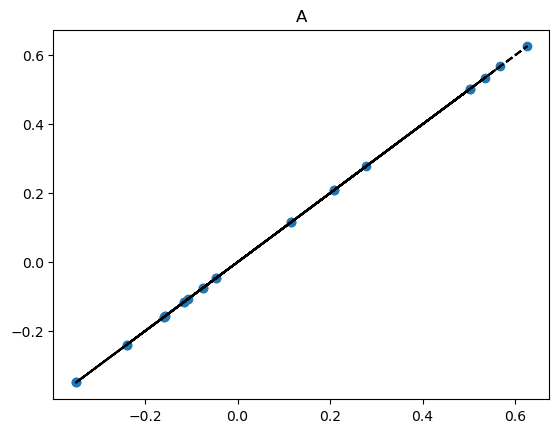

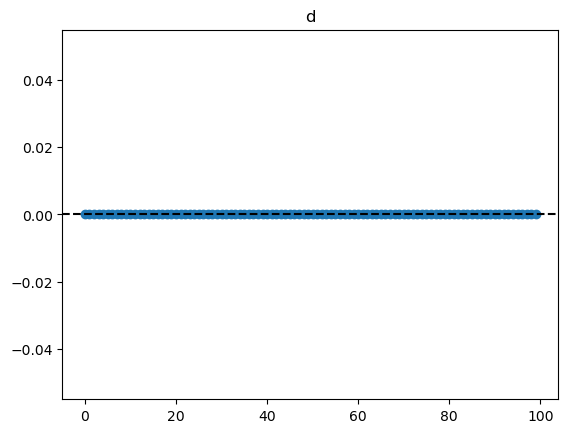

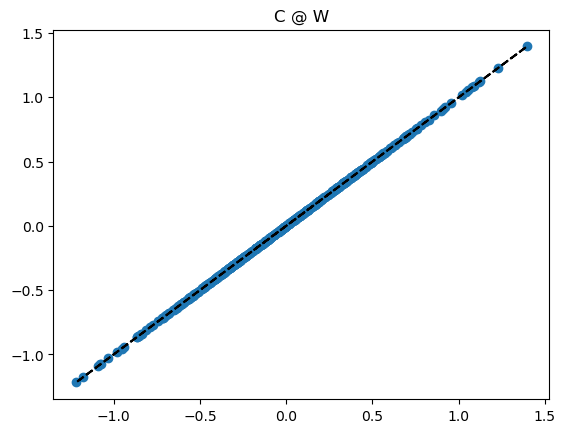

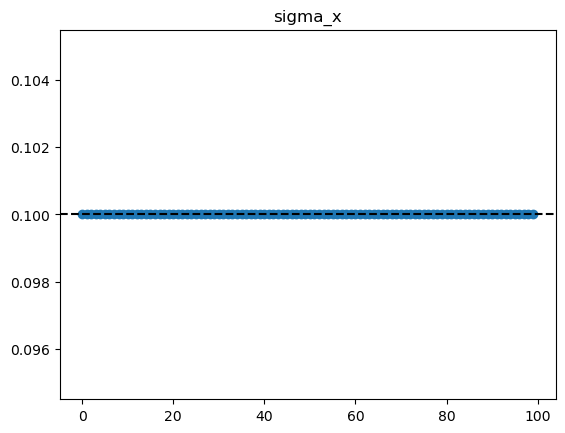

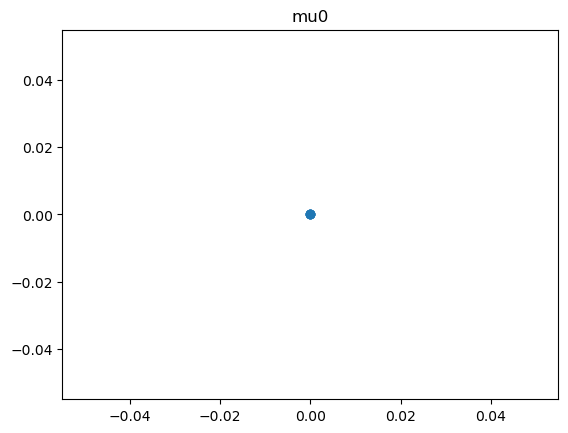

[[[ 1.0000005  0.         0.         0.         0.       ]
  [ 0.         1.0000005  0.         0.         0.       ]
  [ 0.         0.         1.0000005  0.         0.       ]
  [ 0.         0.         0.         1.0000005  0.       ]
  [ 0.         0.         0.        -0.         1.0000005]]] [[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0. -0.  1.]]
Parameter containing:
tensor([[[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.]]], device='cuda:0', requires_grad=True) [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [4]:
# for name, prm in model.named_parameters():
#     if name in ['C', 'W']:
#         continue
#     print(f'Name: {name} - Shape: {prm.shape} - Parameter: {prm}')


# # print(C @ W )
# # print(model.C @ model.W)
# print((C@W - (model.C @ model.W).detach().cpu().numpy()))
# # print(C @ W)
# print(model.Sigma0)

plt.plot(model.A.detach().cpu().numpy().flatten(), A.flatten(), 'o')
# plot y = x line 
plt.plot(A.flatten(), A.flatten(), 'k--')
plt.title('A')
plt.show()

plt.plot(model.d.detach().cpu().numpy(), 'o')
plt.axhline(_d, color='k', linestyle='--')
plt.title('d')
plt.show()

plt.plot((model.C @ model.W).detach().cpu().numpy().flatten(), (C @ W).flatten(), 'o')
# plot y = x line
plt.plot((C @ W).flatten(), (C @ W).flatten(), 'k--')
plt.title('C @ W')
plt.show()

plt.plot(model.sigma_x.detach().cpu().numpy(),'o')
plt.axhline(sigma_x, color='k', linestyle='--')
plt.title('sigma_x')
plt.show()

plt.plot(mu0, model.mu0.detach().cpu().numpy().flatten(), 'o')
plt.plot(mu0, mu0, 'k--')
plt.title('mu0')
plt.show()

print(np.linalg.cholesky(model.Sigma0.detach().cpu().numpy()), np.linalg.cholesky(Sigma0))
print(model.B, B)


torch.Size([1, 1, 5, 1000])


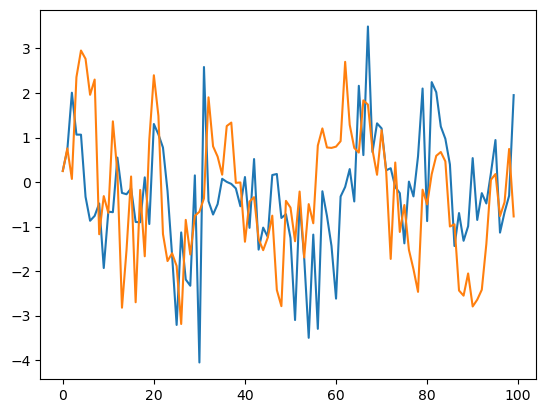

In [6]:
model.freeze_params()
z_samps = model.sample_z(1, trials=1)
print(z_samps.shape)
stop = 100
for i in range(len(z_samps)):
    plt.plot(z_samps[i,0,0, :stop].detach().cpu().numpy())
    plt.plot(z_samps[i,0,1, :stop].detach().cpu().numpy())
    plt.show()

In [6]:
# Load saved neural network
# state_dict = torch.load('my_sequential_model.pth')

In [5]:

model.freeze_params()
print(model.x_dim)

torch.cuda.empty_cache()

torch.manual_seed(0)
np.random.seed(0)

class MyRNNModel(Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNNModel, self).__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True, num_layers=2)
        self.fc = torch.nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

neural_net = MyRNNModel(model.N, 100, model.x_dim)

# # # Substituting the true parameters
# # neural_net = torch.nn.Sequential(
# #                 torch.nn.Linear(model.N, 100),
# #                 torch.nn.ReLU(),
# #                 torch.nn.Linear(100, 100),
# #                 torch.nn.ReLU(),
# #                 torch.nn.Linear(100, 100),
# #                 torch.nn.ReLU(),
# #                 # torch.nn.Linear(100, 100),
# #                 # torch.nn.ReLU(),
# #                 torch.nn.Linear(100, model.x_dim)
# #             )
# # # neural_net.load_state_dict(state_dict)
# # # rec_model = RecognitionModel(model, neural_net=neural_net)

# neural_net.load_state_dict(state_dict)

# rec_model = RecognitionModel(model, neural_net=neural_net, zero_mean_x_tilde=False, cov_change=False)


# Try changing cov
torch.autograd.set_detect_anomaly(True)
class MultiHeadRNN(Module):
    def __init__(self, input_size, hidden_size, output_sizes: dict):
        super(MultiHeadRNN, self).__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True, num_layers=1)
        self.fcs = torch.nn.ModuleDict()
        for key, value in output_sizes.items():
            if key == 'x_tilde':
                self.fcs[key] = torch.nn.Sequential(
                    torch.nn.Linear(hidden_size * 2, value)
                )
            else:
                layer = torch.nn.Linear(hidden_size * 2, value)
                layer.weight.data.fill_(0)
                layer.bias.data.fill_(0)
                self.fcs[key] = torch.nn.Sequential(
                    layer
                )
                # self.fcs[key] = torch.nn.Sequential(
                #     torch.nn.Linear(hidden_size * 2, hidden_size),
                #     torch.nn.ReLU(),
                #     torch.nn.Linear(hidden_size, value)
                # )
    def forward(self, x):
        out, _ = self.rnn(x)
        ret = dict()
        for key, fc in self.fcs.items():
            ret[key] = fc(out)
        return ret
neural_net = MultiHeadRNN(input_size=100,
                    hidden_size=100,output_sizes={'x_tilde': 100,'delta_W': 500})
rec_model = RecognitionModel(model, neural_net=neural_net, cov_change=True)

train_params = {'batch_size': None, 'step_size': 1000, 'lrate': 1e-3, 'max_steps': 1001, 'n_mc_x': 50, 'n_mc_z': 50, 'batch_mc_z': 25, 'print_deltas': True}
rec_model.train_recognition_model(rec_model.training_params(**train_params))
rec_model.plot_LL()

100
step 0 LL -1.5193 Entropy -2.7778 ln p(y|z) -1.3094 ln p(z) -1.4203 ln p(v|z) 0.0000
dWs: (0.0, 0.0)
step 1 LL -1.5003 Entropy -2.7270 ln p(y|z) -1.2927 ln p(z) -1.4242 ln p(v|z) 0.0000
dWs: (0.11606648564338684, -0.11655199527740479)
step 2 LL -1.4797 Entropy -2.6661 ln p(y|z) -1.2749 ln p(z) -1.4288 ln p(v|z) 0.0000
dWs: (0.230201855301857, -0.23285432159900665)
step 3 LL -1.4572 Entropy -2.5880 ln p(y|z) -1.2559 ln p(z) -1.4379 ln p(v|z) 0.0000
dWs: (0.3483724892139435, -0.3536660075187683)
step 4 LL -1.4302 Entropy -2.4847 ln p(y|z) -1.2328 ln p(z) -1.4626 ln p(v|z) 0.0000
dWs: (0.4678320586681366, -0.4782122075557709)
step 5 LL -1.4000 Entropy -2.3473 ln p(y|z) -1.2069 ln p(z) -1.5140 ln p(v|z) 0.0000
dWs: (0.5886048674583435, -0.5974680185317993)
step 6 LL -1.3773 Entropy -2.1748 ln p(y|z) -1.1878 ln p(z) -1.6154 ln p(v|z) 0.0000
dWs: (0.7165801525115967, -0.7167717218399048)
step 7 LL -1.3646 Entropy -2.0091 ln p(y|z) -1.1772 ln p(z) -1.7384 ln p(v|z) 0.0000
dWs: (0.85484749

KeyboardInterrupt: 

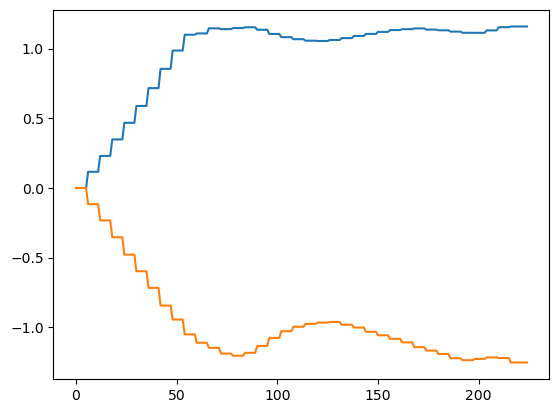

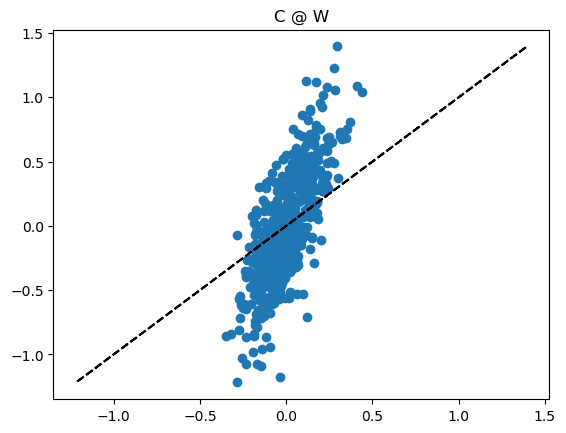

torch.Size([80, 100, 20])
(100, 5, 20)


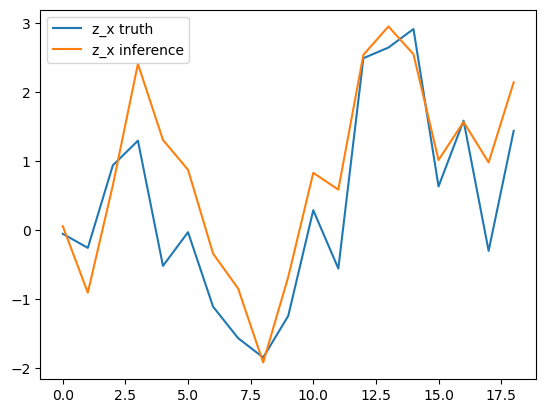

0.7880163279442666 z_0
0.8614369336744444 z_1
0.7643581233344392 z_2
0.8511457820007564 z_3
0.7387979441428867 z_4
(100, 100, 20)


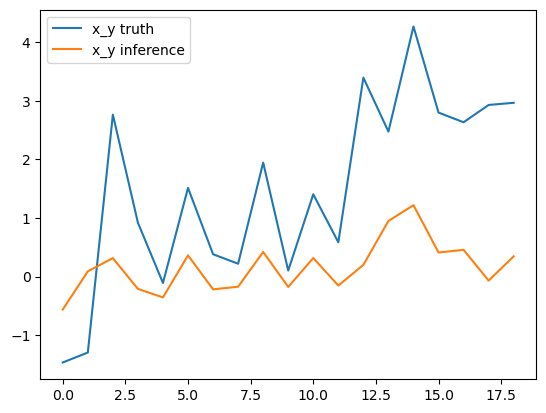

In [7]:
rec_model.freeze_params()

# Evaluate changing cov stuff
plt.plot(rec_model.dWs)
plt.show()
# The first final W
pseudo_obs = rec_model.get_x_tilde(rec_model.gen_model.Y, False)
W_final = rec_model.gen_model_W(pseudo_obs)[0,0,...].detach().cpu().numpy()
plt.plot((rec_model.gen_model.C.detach().cpu().numpy() @ W_final).flatten(), (rec_model.gen_model.C @ rec_model.gen_model.W).detach().cpu().numpy().flatten(), 'o')
plt.plot((rec_model.gen_model.C @ rec_model.gen_model.W).detach().cpu().numpy().flatten(), (rec_model.gen_model.C @ rec_model.gen_model.W).detach().cpu().numpy().flatten(), 'k--')
plt.title('C @ W')
plt.show()


print(rec_model.gen_model.Y.shape)
z = rec_model.test_z(Tensor(Y).to(device))
# z = z.detach().cpu().numpy()
print(z.shape)

start = 0
stop = -1
plt.plot(v[0,0,start:stop], label = 'z_x truth')
# plt.plot(v[0,1,:100], label = 'z_y truth')
plt.plot(z[0,0,start:stop], label = 'z_x inference')
# plt.plot(z[0,1,:100], label = 'z_y inference')
plt.legend()
plt.show()

# for i in range(5):
#     plt.plot(z[0,i,:stop], label = 'z_x inference')
# plt.show()
# for i in range(5):
#     plt.plot(v[0,i,:stop], label = 'z_x truth')   
#     # plt.legend()
# plt.show()

# print R^2 for x and y decoding using sklearn
# print(r2_score(v[0,1,:], z[0,1,:]))
# print(r2_score(v[0,0,:], z[0,0,:]))

for i in range(rec_model.gen_model.b):
    # print(r2_score(v[0,i,train_len:], z[0,i,train_len:]), 'z_{}'.format(i))
    print(r2_score(v[train_trials:, i, :].flatten(), z[train_trials:, i, :].flatten()), 'z_{}'.format(i))

x_tilde = rec_model.get_x_tilde(Tensor(Y).to(device)).detach().cpu().numpy()
print(x_tilde.shape)
stop = -1
# plt.plot(x_noise_free[0,0,:stop], label = 'x_x truth')
# plt.plot(x_tilde[0,0,:stop], label = 'x_x inference')
plt.plot(x_noise_free[0,1,:stop], label = 'x_y truth')
plt.plot(x_tilde[0,1,:stop], label = 'x_y inference')
plt.legend()
plt.show()

# # print R^2 for x_tilde
# for i in range(rec_model.gen_model.x_dim):
#     print(r2_score(x_noise_free[0,i,:], x_tilde[0,i,:]), 'x_{}'.format(i))

# _, _, Ks, Cs = rec_model.kalman_covariance() # TODO: should I use prev_mu and prev_Sigma?
# _ , mus_smooth, _ = rec_model.kalman_means(Tensor(x_noise_free[None, ..., :train_len]).to(device), Ks, Cs) # (T_test, 1, ntrials, b)
# # _ , mus_smooth, _ = rec_model.kalman_means(Tensor(x[None, ...]).to(device), Ks, Cs) # (T_test, 1, ntrials, b)
# mus_smooth = mus_smooth.detach().cpu().numpy().squeeze(1).transpose(1, 2, 0)
# print(mus_smooth.shape)
# stop = 100
# plt.plot(v[0,0,:stop], label = 'z_x truth')
# plt.plot(mus_smooth[0, 0,:stop], label = 'z_x inference')
# plt.plot(v[0,1,:stop], label = 'z_y truth')
# plt.plot(mus_smooth[0, 1,:stop], label = 'z_y inference')
# plt.legend()
# plt.show()

# # print R^2 for x and y smoothing using sklearn
# print(r2_score(v[0,1,:], mus_smooth[0, 1,:]))
# print(r2_score(v[0,0,:], mus_smooth[0, 0,:]))


In [9]:
_A = Tensor(A).to(device)
_W = Tensor(W).to(device)
_Q = Tensor(B @ B.T).to(device)
_R = Tensor(np.eye(N) * sigma_x**2).to(device)
_Sigma0 = Tensor(Sigma0).to(device)
_mu0 = Tensor(mu0).to(device)
gaussian_Y = Tensor(Y - Y.mean(2)[..., None]).to(device)
_, _, Ks, Cs = general_kalman_covariance(A=_A, W=_W, Q=_Q, R=_R, b=z_dim, x_dim=x_dim, Sigma0=_Sigma0, T=2000, get_sigma_tilde=False, smoothing=True)
_, gaussian_mus_smooth, _ = general_kalman_means(A=_A, W=_W, b=z_dim, mu0=_mu0, x_hat=gaussian_Y[None, ...], Ks=Ks, Cs=Cs, smoothing=True)

torch.Size([2000, 1, 1, 5])
0.7840359015975084
0.7870440645095884
0.7965260065831103
0.7885589265264047
0.7882677710919533


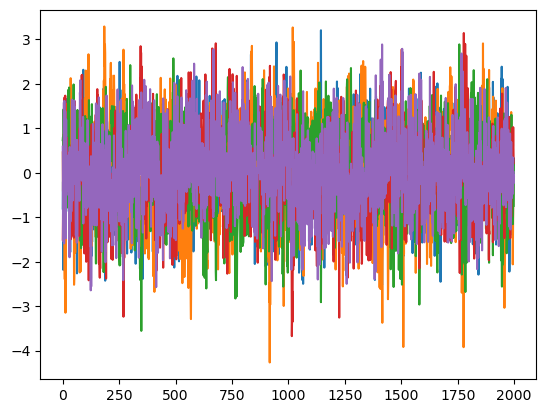

In [10]:
print(gaussian_mus_smooth.shape) # (T, n_mc, ntrials, b)
gaussian_z = gaussian_mus_smooth.detach().cpu().numpy().squeeze(1).transpose(1, 2, 0) # (ntrials, b, T)
for i in range(5):
    plt.plot(gaussian_z[0,i,:stop], label = 'z inf')
    print(r2_score(v[0,i,:], gaussian_z[0,i,:]))

In [25]:
# Checking what sampled posteriors look like
matheron_pert = rec_model.sample_matheron_pert(100, 1)
print(matheron_pert.shape)
# x_hat = Tensor(x[None, ...]).to(device) - matheron_pert[..., :x_tilde.shape[-1]]
x_hat = Tensor(x_noise_free[None, :, :, :train_len]).to(device) - matheron_pert
print(x_hat.shape)
# _, _, Ks, Cs = rec_model.kalman_covariance() # TODO: should I use prev_mu and prev_Sigma?
_ , _mus_smooth, _ = rec_model.kalman_means(x_hat, Ks, Cs) # (batch_size, n_mc_z, ntrials, b)
_mus_smooth = _mus_smooth.permute(1,2,3,0).squeeze().detach().cpu().numpy()
print(_mus_smooth.shape)

# True posterior mean
_ , mus_smooth, _ = rec_model.kalman_means(Tensor(x_noise_free[None, ..., :train_len]).to(device), Ks, Cs) # (T_test, 1, ntrials, b)
mus_smooth = mus_smooth.detach().cpu().numpy().squeeze().T
print(mus_smooth.shape)

torch.Size([100, 1, 100, 1000])
torch.Size([100, 1, 100, 1000])
(100, 5, 1000)
(5, 1000)


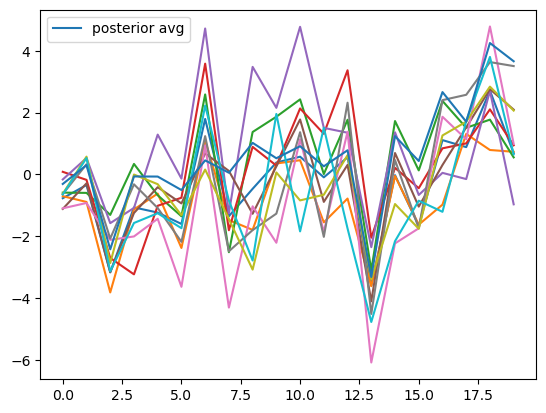

0.9878795933412897
0.988433934323742


In [26]:
# stop = 100
# for i in range(len(_mus_smooth)):
#     plt.plot(_mus_smooth[i,0,:stop])
#     # plt.plot(_mus_smooth[i,0,1,:stop])
#     # plt.show()
# plt.show()

stop = 20
posterior_avg = _mus_smooth.mean(0)
posterior_std = _mus_smooth.std(0)
# prior_avg = z_samps.mean(0)
plt.plot(posterior_avg[0,:stop], label = 'posterior avg')
# plt.plot(mus_smooth[0,:stop], label = 'smoothing')
# plt.plot(prior_avg[0,:stop], label = 'prior avg')
# plt.plot(z_samps[0,0,:stop], label = 'prior sample')
for i in range(10):
    plt.plot(_mus_smooth[i,0,:stop])
plt.legend()
plt.show()
# print R^2 between posterior mean and smoothing
print(r2_score(mus_smooth[0,:], posterior_avg[0,:]))
print(r2_score(mus_smooth[1,:], posterior_avg[1,:]))

In [8]:
# # dill.dump(rec_model, open('synthetic_rec.pkl', 'wb'))
# dill.dump(rec_model, open('synthetic__small_rec.pkl', 'wb'))
# dill.dump(model, open('synthetic__small_gen.pkl', 'wb'))

# dill.dump(model, open('synthetic_gen_small_t.pkl', 'wb'))
model = dill.load(open('synthetic_gen_small_t.pkl', 'rb'))